In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import display, clear_output
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import svm, model_selection, metrics

device = (
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [2]:
class MarkerImageDataset(Dataset):
    def __init__(self, f: str) -> None:
        super().__init__()
        self.dataset = pd.read_pickle(f)

        self.img = torch.as_tensor(np.stack(self.dataset["images"], axis=0), dtype=torch.float32).to(device)[:, None, :, :]
        self.label = torch.as_tensor(np.vstack(self.dataset["label"]), dtype=torch.float32).to(device)

    def __len__(self) -> int:
        return self.dataset.shape[0]
    
    def __getitem__(self, idx: int) -> dict:
        return self.img[idx], self.label[idx]

dataset = MarkerImageDataset("data/set4.pkl")
print(dataset.dataset.head())
print(dataset.dataset.iloc[0].images.shape)

IMAGE_WIDTH, IMAGE_HEIGHT = dataset.dataset.iloc[0].images.shape
print(f"Image size: {IMAGE_WIDTH}x{IMAGE_HEIGHT}")

                                                  images  label
23290  [[0.40643760463074197, 0.3982520862496269, 0.4...      1
47604  [[0.12182608906416852, 0.19741380979252504, 0....      1
54068  [[0.5783613612865524, 0.4507420836595933, 0.47...      1
43583  [[0.31308472117490954, 0.30893375779528137, 0....      1
56001  [[0.2915222336036848, 0.27913560835588913, 0.2...      1
(21, 21)
Image size: 21x21


In [5]:
TEST_SIZE = 0.2
BATCH_SIZE = 32

dataset = MarkerImageDataset("data/set4.pkl")
test_size = int(len(dataset) * TEST_SIZE)
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

HEAVOSIDE_VALUES = torch.full((BATCH_SIZE,), 0.0).to(device)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Train: {train_size}, Test: {test_size}, Total: {len(dataset)} (Batch: {BATCH_SIZE})")
print(dataset.img.shape, dataset.label.shape)

print("Labels:", dataset.label)
dataset.dataset.head()

Train: 103805, Test: 25951, Total: 129756 (Batch: 32)
torch.Size([129756, 1, 21, 21]) torch.Size([129756, 1])
Labels: tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')


images  label
23290  [[0.40643760463074197, 0.3982520862496269, 0.4...      1
47604  [[0.12182608906416852, 0.19741380979252504, 0....      1
54068  [[0.5783613612865524, 0.4507420836595933, 0.47...      1
43583  [[0.31308472117490954, 0.30893375779528137, 0....      1
56001  [[0.2915222336036848, 0.27913560835588913, 0.2...      1

In [59]:


def train_loop(total_epoch, epoch, dataloader, model, loss_fn, optimizer, last_accuracy, last_loss):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print_status(total_epoch, epoch, loss, size, current, last_accuracy, last_loss)

def test_loop(total_epoch, epoch, dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += torch.round(torch.abs(pred - y)).sum().item()

    test_loss /= num_batches
    accuracy = (size-correct) / size
    
    print_status(total_epoch, epoch, 0, 1, 1, accuracy, test_loss)
    return (accuracy, test_loss)


def print_status(total_epoch, epoch, loss, total_batch, batch, test_accuracy, test_loss):
    N = 30
    progressbar = ("="*round((batch/total_batch)*N) + ">")[:N].ljust(N)
    s = f"Epoch {total_epoch:04d}/{epoch:04d} loss: {loss:02.5f} [{progressbar}]"


    if test_accuracy is not None:
        s += f" Test: Accuracy: {100*test_accuracy:>0.3f}%, Test loss: {test_loss:>8f}     "
    
    print(s, end="\r", flush=True)


In [65]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.convStack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=2, padding_mode="zeros"), # 21x21 -> 21x21
            nn.MaxPool2d(kernel_size=2, stride=2), # 21x21 -> 10x10
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=12, out_channels=8, kernel_size=3, stride=1, padding=1, padding_mode="zeros"),
            nn.MaxPool2d(kernel_size=2, stride=2), #10x10 -> 5x5
            nn.Dropout(0.1),
        )

        self.flattenLayer = nn.Flatten()

        self.linearStack = nn.Sequential(
            nn.Linear(5*5 * 8, 6),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(6, 1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_ = self.convStack(x)
        #print(x_.shape)
        x_ = self.flattenLayer(x_)
        return self.linearStack(x_)

if "model" in locals():
    del model

model = NeuralNetwork().to(device)


Epoch 0300/0300 loss: 0.00000 [==============================] Test: Accuracy: 99.803%, Test loss: 0.016756     
Done!


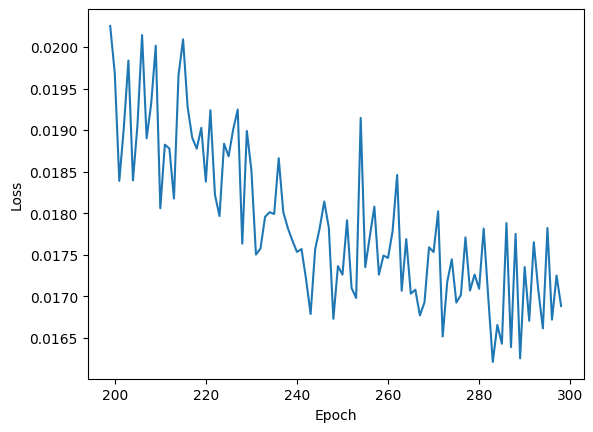

In [66]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 300

fig, ax = plt.subplots(1,1)

#ax.set_xlim(0, epochs)
#plt.show()

loss_history = []
accuracy_history = []
epoch_history = []

accuracy = None
loss = None

for t in range(epochs):
    ax.cla()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.plot(epoch_history[-100:], loss_history[-100:])
    #ax.plot(epoch_history, accuracy_history)
    display(fig)
    
    train_loop(epochs, t+1, train_dataloader, model, loss_fn, optimizer, accuracy, loss)
    accuracy, loss = test_loop(epochs, t+1, test_dataloader, model, loss_fn)

    loss_history.append(loss)
    accuracy_history.append(accuracy)
    epoch_history.append(t)

    clear_output(wait = True)

print_status(epochs, epochs, 0, 1, 1, accuracy, loss)
print("")
print("Done!")

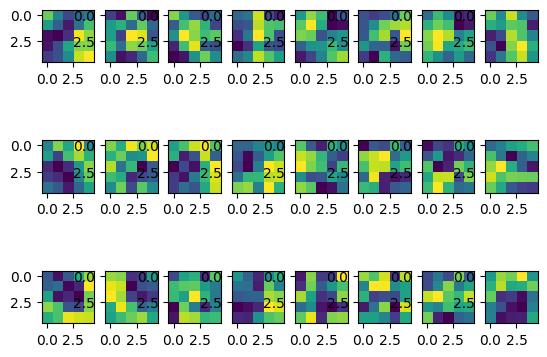

In [47]:


filter = model.convStack[0].weight.data.clone().to("cpu")
filter.shape

for i in range(24):
    plt.subplot(3, 8, i+1)
    plt.imshow(filter[i, 0])

plt.show()

In [68]:
BASE_DIR = "model"
ID = "modelv4.1"
pytorch_total_params = round(sum(p.numel() for p in model.parameters())/1000)

torch.save(model.state_dict(), os.path.join(BASE_DIR, ID + f"_{pytorch_total_params}k_.pth"))
torch.jit.script(model).save(os.path.join(BASE_DIR, ID + f"_{pytorch_total_params}k_script.pth"))

In [64]:
loss_fn = nn.BCELoss()
model_under_test = torch.jit.load("model/modelv2.2_9k_script.pth")
acc, loss = test_loop(1, 1, test_dataloader, model_under_test, loss_fn)
pytorch_total_params = round(sum(p.numel() for p in model.parameters())/1000)
print("\nParameters:", pytorch_total_params)


Epoch 0001/0001 loss: 0.00000 [==============================] Test: Accuracy: 99.981%, Test loss: 0.001013     
Parameters: 5
